#                                                             Fault detection in semiconductor manufacturing

### Import Libraries

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from scipy.stats import shapiro
# imputer
from sklearn.impute import SimpleImputer, KNNImputer
import missingno as msno
from sklearn.feature_selection import VarianceThreshold
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

In [71]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
#from sklearn.metrics import scorer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import RandomizedSearchCV

### Import SECOM Dataset

In [3]:
url1 ='https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom.data'
names = ["feature" + str(x) for x in range(1, 591)]
df1 = pd.read_csv(url1,sep=" ", names=names, na_values = "NaN",header=None)
#df1.head()

url2 ='https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom_labels.data'
df2 = pd.read_csv(url2,sep=" ",names = ["Result","Date"])

#df2.head()

### The time feature will not be utilised 

In [4]:
df2 = df2.drop(['Date'], axis = 1)

In [5]:
secom_df = pd.merge(df1, df2,left_index=True,right_index=True)
secom_df.head()

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,...,feature582,feature583,feature584,feature585,feature586,feature587,feature588,feature589,feature590,Result
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,-1
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,-1
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,-1
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,-1


### Visualise the distribution of y variable

In [6]:
# unique value of the target variable
secom_df['Result'].unique()

array([-1,  1], dtype=int64)

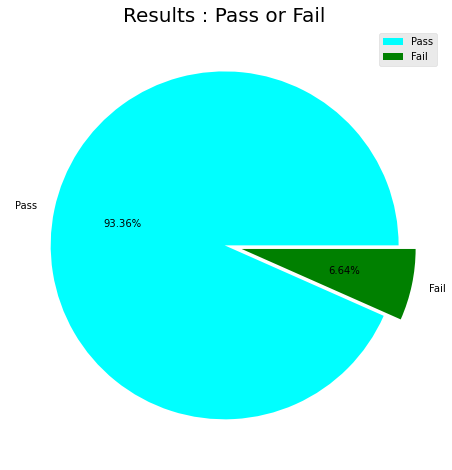

<AxesSubplot:>

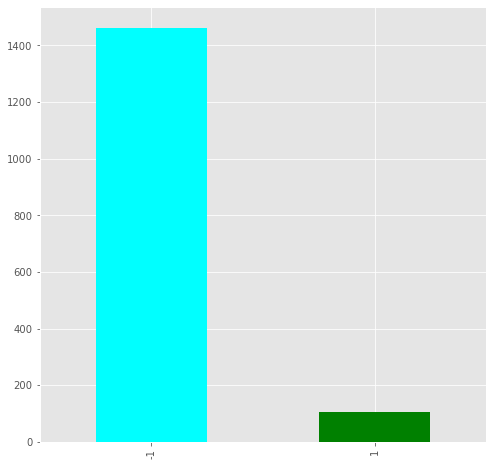

In [7]:
labels = ['Pass', 'Fail']
size = secom_df['Result'].value_counts()
colors = ['cyan', 'green']
explode = [0, 0.1]
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (8,8)
plt.pie(size, labels = labels, colors = colors, explode = explode, autopct= "%.2f%%")
plt.axis('off')
plt.title('Results : Pass or Fail', fontsize = 20)
plt.legend()
plt.show()
secom_df['Result'].value_counts().plot(kind = "bar", color = colors)

#### The target variable is highly imbalanced with 93.36% leaning towards pass class and only 6.64% for the fail class

Text(0.5, 1.0, 'Correlation for all features')

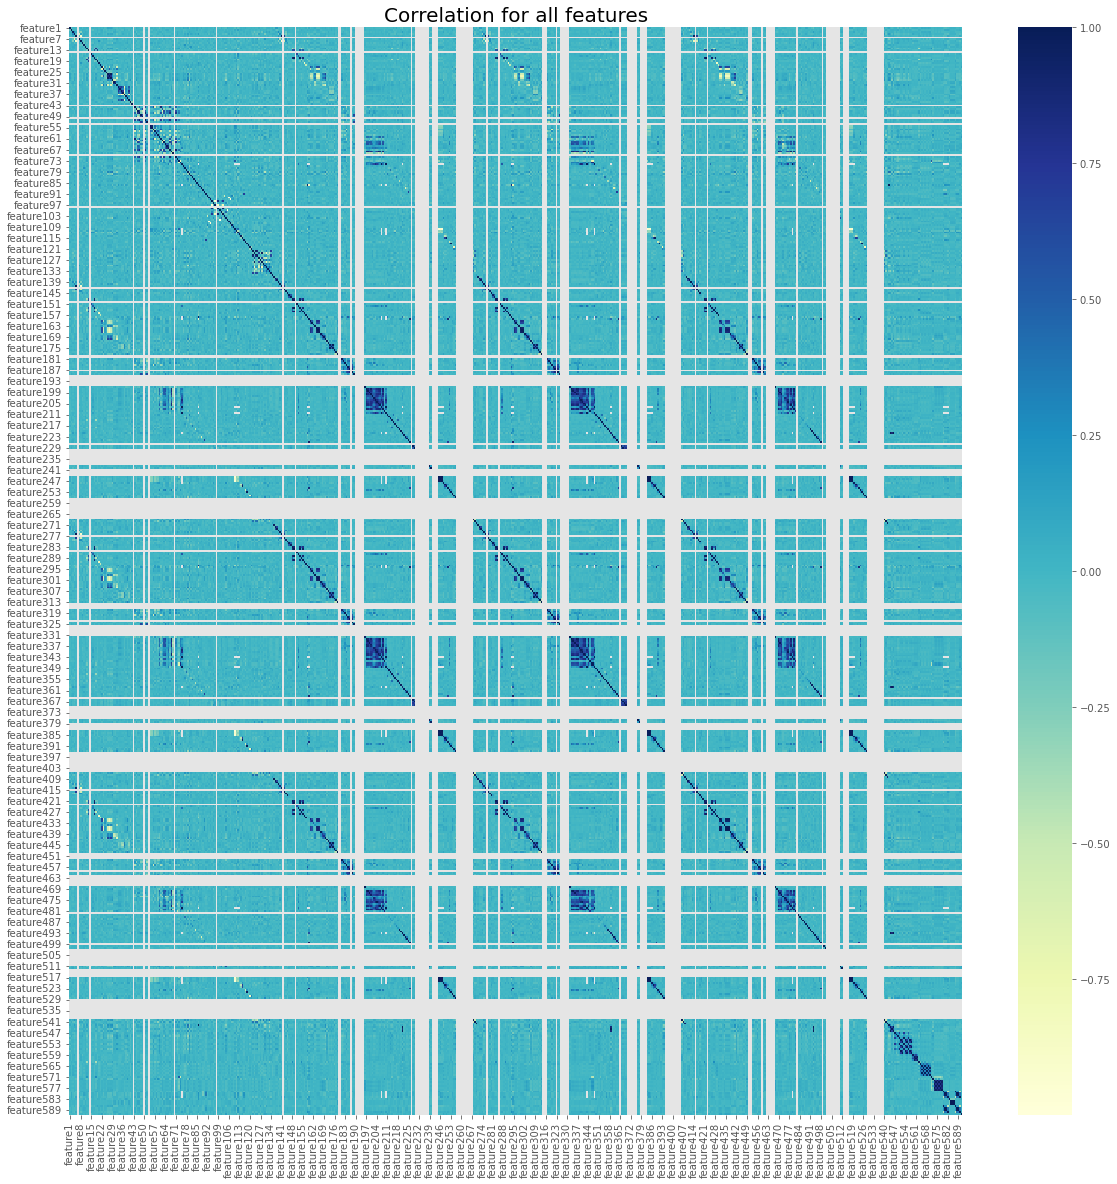

In [8]:
plt.rcParams['figure.figsize'] = (20, 20)
sns.heatmap(secom_df.corr(), cmap = "YlGnBu")
plt.title('Correlation for all features', fontsize = 20)

### Check for missing values

In [9]:
#check if there is any null values in the dataset
secom_df.isnull().any().any()

True

<AxesSubplot:>

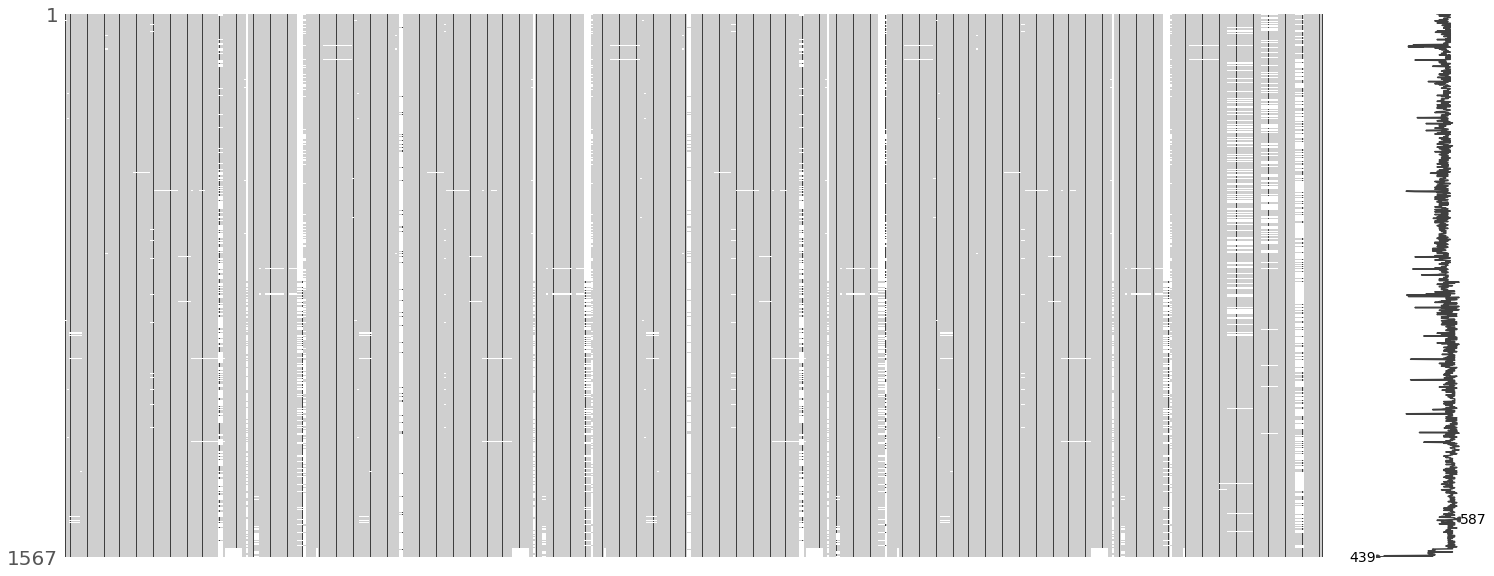

In [10]:
msno.matrix(secom_df)

A lot of empty spot in the columns which indicates missing values 

In [11]:
# Percentage of missing values per features
percent_missing = (secom_df.isnull().sum() * 100 / len(secom_df)).round(3).sort_values(ascending=False)
percent_missing
missing_value_df = pd.DataFrame({'percent_missing': percent_missing})
missing_value_df


,percent_missing
feature158,91.193
feature293,91.193
feature294,91.193
feature159,91.193
feature493,85.578
...,...
feature121,0.000
feature157,0.000
feature496,0.000
feature495,0.000


##### Number of features that have a percentage of missing value over 50% that will not have a significant impact on the ML model hence serve no purpose

In [12]:
len(missing_value_df[missing_value_df['percent_missing'] > 50])

28

#### Unique Value Analysis

In [13]:
unique_v = secom_df.apply(pd.Series.nunique)

In [14]:
# Count number of features that only have 1 unique values
len(unique_v[unique_v == 1])

116

116 features contrain only 1 contant value therefore they shall be removed as they will not affect the prediction made by the model and these columns will teach us nothing about the target variable.

# Data Preparation

### Spliting the dataset 

In [15]:
#Split data into features x and target variable 

y = secom_df['Result'].copy()

x = secom_df.drop(['Result'], axis = 1).copy()

In [16]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.30, random_state= 1, stratify= y)

print("Shape of X train :", xtrain.shape)
print("Shape of X test :", xtest.shape)
print("Shape of Y train :", ytrain.shape)
print("Shape of Y test :", ytest.shape)

Shape of X train : (1096, 590)
Shape of X test : (471, 590)
Shape of Y train : (1096,)
Shape of Y test : (471,)


## Feature Engineering

#### Remove Features having percentage of missing value more than 50%

In [17]:
def perctna(df, threshold):
        col = df.columns[(df.isnull().sum()*100 /len(df))>threshold]
        return col.tolist()

na_col = perctna(xtrain, 50)
xtrain_na = xtrain.drop(na_col, axis = 1)
xtrain_na.shape

(1096, 566)

#### Remove low variance features

In [18]:
# spot columns where 100% of the values are similar
var_thres=VarianceThreshold(threshold=0)
var_thres.fit(xtrain_na)

cons_col = [column for column in xtrain_na.columns if column not in xtrain_na.columns[var_thres.get_support()]]
xtrain_c = xtrain_na.drop(cons_col, axis = 1)
xtrain_c.shape

(1096, 450)

In [19]:
#Dropping the Columns in test dataset also

xtest_lv = xtest.copy()
xtest_lv = xtest_lv.drop(na_col, axis =1)
xtest_lv = xtest_lv.drop(cons_col, axis=1)
xtest_lv.shape

(471, 450)

##### OUTLIER IMPUTATION using 3s rule

In [20]:
def outliers(feat):
 upper_limit = feat.mean() + 3*feat.std()
 lower_limit = feat.mean() - 3*feat.std()

 feat = np.where(
    feat >upper_limit,
    upper_limit,
    np.where(
       feat <lower_limit,
        lower_limit,
        feat ))
 return feat

x_train_oi =xtrain_c.copy()
for column in x_train_oi:
  x_train_oi[column] = outliers(x_train_oi[column])

#### Missing value imputation

In [21]:
from sklearn.model_selection import GridSearchCV
model_params = {
        'KNN': {'model': KNNImputer(),
                'params' :{
                    'n_neighbors': list(range(1,30)),
                    'weights' : ['uniform', 'distance'],
                    'add_indicator': [True, False]
                        }
               }
}

#### Perform feature Scaling

In [22]:
col_name = list(x_train_oi.columns)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

xtrain_s = scaler.fit_transform(x_train_oi)

xtest_s =scaler.transform(xtest_lv)

xtrain_s = pd.DataFrame(xtrain_s, columns=col_name)
xtest_s = pd.DataFrame(xtest_s, columns=col_name)


In [23]:
scores = []
for model_name, mp in model_params.items():
    clf =  GridSearchCV(mp['model'], mp['params'], scoring = 'accuracy', cv=5)
    clf.fit(xtrain_s, ytrain)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_,
        'best_estimator':clf.best_estimator_,
    })
gridsearch = pd.DataFrame(scores, columns = ['model','best_score','best_params','best_estimator'])
gridsearch

,model,best_score,best_params,best_estimator
0,KNN,NaN,"{'add_indicator': True, 'n_neighbors': 1, 'wei...","KNNImputer(add_indicator=True, n_neighbors=1)"


In [24]:
numColumns = xtrain_s.select_dtypes(include=np.number).columns.tolist()

#### Using KNN Imputer with the best parameters

In [25]:
#Using KNN Imputation Method

numColumns = xtrain_s.select_dtypes(include=np.number).columns.tolist()

# initialize imputer
imputer = KNNImputer(n_neighbors = 1,weights='uniform')

# fit the imputer on X_train. pass only numeric columns.
imputer.fit(xtrain_s[numColumns])

# transform the data using the fitted imputer
xtrain_imp = imputer.transform(xtrain_s[numColumns])
xtest_imp = imputer.transform(xtest_s[numColumns])
# put the output into DataFrame. remember to pass columns used in fit/transform
xtrain_imp = pd.DataFrame(xtrain_imp, columns=numColumns)
xtest_imp = pd.DataFrame(xtest_imp, columns=numColumns)

#### Perform a model evaluation before any feature selection and balancing 

In [37]:
# Using logistic Regression classification technique to predict faulty wafers

lg_model = LogisticRegression()
clf = lg_model.fit(xtrain_imp, ytrain)
y_pred_b = lg_model.predict(xtest_imp)

Classification report: 

               precision    recall  f1-score   support

          -1       0.93      0.97      0.95       440
           1       0.08      0.03      0.05        31

    accuracy                           0.91       471
   macro avg       0.51      0.50      0.50       471
weighted avg       0.88      0.91      0.89       471



The accuracy Score is 0.910828025477707


The ROC-AUC Score is 0.5024926686217009


Confusion Matrix:


Confusion Matrix:


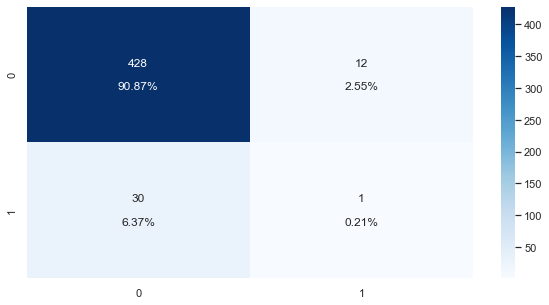

In [44]:
print(f'Classification report: \n\n {classification_report(ytest,y_pred_b)}')
print('\n')
print(f'The accuracy Score is {accuracy_score(ytest, y_pred_b)}')
print('\n')
print(f'The ROC-AUC Score is {roc_auc_score(ytest, y_pred_b)}')
print('\n')
print('Confusion Matrix:')
cf_matrix = confusion_matrix(ytest, y_pred_b)

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [group_counts,group_percentages]
labels = [f"{v1}\n\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, cmap='Blues', fmt='')
sns.set(rc={'figure.figsize':(10,5)})

print('\n')
print('Confusion Matrix:')

### Feature Selection using Boruta

In [29]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state=1, n_estimators=1000, max_depth=5)
boruta_selector = BorutaPy(rfc, n_estimators='auto', verbose=2, random_state=1)
boruta_selector.fit(np.array(xtrain_imp), np.array(ytrain))

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	450
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	450
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	450
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	450
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	450
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	450
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	450
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	435
Iteration: 	9 / 100
Confirmed: 	1
Tentative: 	14
Rejected: 	435
Iteration: 	10 / 100
Confirmed: 	1
Tentative: 	14
Rejected: 	435
Iteration: 	11 / 100
Confirmed: 	1
Tentative: 	14
Rejected: 	435
Iteration: 	12 / 100
Confirmed: 	2
Tentative: 	13
Rejected: 	435
Iteration: 	13 / 100
Confirmed: 	2
Tentative: 	13
Rejected: 	435
Iteration: 	14 / 100
Confirmed: 	2
Tentative: 	13
Rejected: 	435
Iteration: 	15 / 100
Confirmed: 	2
Tentative: 	13
Rejected: 	435
Iteration: 	16 / 100
Confirmed: 	3
Tentat

BorutaPy(estimator=RandomForestClassifier(max_depth=5, n_estimators=105,
                                          random_state=RandomState(MT19937) at 0x1B4FA9AF740),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x1B4FA9AF740, verbose=2)

In [30]:
# Number of selected features by Boruta
print("No. of significant features: ", boruta_selector.n_features_) 

print("")

# The mask of selected tentative features, which haven't gained enough support during the max_iter number of iterations
print("Tentative Features:", xtrain_imp.columns[boruta_selector.support_weak_].tolist())

No. of significant features:  11

Tentative Features: ['feature342', 'feature478']


In [31]:
selected_features = pd.DataFrame({'Feature':list(xtrain_imp.columns),
                                       'Ranking':boruta_selector.ranking_})
selected_features.sort_values(by='Ranking').head(20)

,Feature,Ranking
140,feature154,1
369,feature476,1
214,feature268,1
59,feature65,1
281,feature349,1
60,feature66,1
345,feature442,1
54,feature60,1
403,feature540,1
330,feature427,1


##### Only Ranking 1 and 2 is taken into consideration for the significant features that will have an impact on the model

In [32]:
# Using the BorutaPy to select the important features to further train our model

selected_features = xtrain_imp.columns[boruta_selector.support_].tolist()

tentative_features = xtrain_imp.columns[boruta_selector.support_weak_].tolist()

approved_features = selected_features + tentative_features

xtrain_fil = xtrain_imp[approved_features]

xtest_fil = xtest_imp[approved_features]

### Handling imbalanced dataset

In [35]:
from imblearn.over_sampling import SMOTE

sm = SMOTE()

xtrain_sm, ytrain_sm = sm.fit_resample(xtrain_fil, ytrain)

In [45]:
print('Before sampling :\n', ytrain.value_counts())
print('\n')
print('After sampling:\n', ytrain_sm.value_counts())

Before sampling :
 -1    1023
 1      73
Name: Result, dtype: int64


After sampling:
 -1    1023
 1    1023
Name: Result, dtype: int64


In [35]:
classifiers = [['Naive Bayes :', GaussianNB()],
               ['RandomForest :',RandomForestClassifier()],
               ['SVM :', SVC()],
               ['LogisticRegression :', LogisticRegression()]]

for name,classifier in classifiers:
    clf=classifier.fit(xtrain_sm,ytrain_sm)
    y_pred=classifier.predict(xtest_fil)
    print(f'\n {name} \n')
    print(f'Training Score for {name}  {clf.score(xtrain_sm,ytrain_sm) * 100:.2f}' )
    print(f'Testing Score for {name} {clf.score(xtest_fil,ytest) * 100:.2f}' )
    print(f'Classification report  \n {classification_report(ytest,y_pred)}' )
    print(f'Confusion matrix  \n {confusion_matrix(ytest,y_pred)}' )
    print(f'ROC AUC  : {roc_auc_score(ytest,y_pred)}' )
    tn, fp, fn, tp = confusion_matrix(ytest,y_pred).ravel()
    print('sensitivity is %f',1.*tp/(tp+fn))
    print('specificity is %f',1.*tn/(tn+fp))
    print('accuracy is %f',1.*(tp+tn)/(tp+tn+fp+fn))
    print('balanced accuracy is %',1./2*(1.*tp/(tp+fn)+1.*tn/(tn+fp)))
    print('Type1 Error is %f',1.*(fp))
    print('Type2 Error is %f',1.*(fn))
 


 Naive Bayes : 

Training Score for Naive Bayes :  67.89
Testing Score for Naive Bayes : 78.56
Classification report  
               precision    recall  f1-score   support

          -1       0.96      0.80      0.87       440
           1       0.17      0.58      0.26        31

    accuracy                           0.79       471
   macro avg       0.57      0.69      0.57       471
weighted avg       0.91      0.79      0.83       471

Confusion matrix  
 [[352  88]
 [ 13  18]]
ROC AUC  : 0.6903225806451614
sensitivity is %f 0.5806451612903226
specificity is %f 0.8
accuracy is %f 0.7855626326963907
balanced accuracy is % 0.6903225806451614
Type1 Error is %f 88.0
Type2 Error is %f 13.0

 RandomForest : 

Training Score for RandomForest :  100.00
Testing Score for RandomForest : 90.02
Classification report  
               precision    recall  f1-score   support

          -1       0.94      0.95      0.95       440
           1       0.21      0.19      0.20        31

    accur

In [36]:
classifiers = [['SVM :', SVC(C=10.0, gamma=1.0, kernel='linear')],
               ['LogisticRegression :', LogisticRegression(penalty='l2',C=2,solver='liblinear',max_iter=600)]]

for name,classifier in classifiers:
    clf=classifier.fit(xtrain_sm,ytrain_sm)
    y_pred=classifier.predict(xtest_fil)
    print(f'\n {name} \n')
    print(f'Training Score for {name}  {clf.score(xtrain_sm,ytrain_sm) * 100:.2f}' )
    print(f'Testing Score for {name} {clf.score(xtest_fil,ytest) * 100:.2f}' )
    print(f'Classification report  \n {classification_report(ytest,y_pred)}' )
    print(f'Confusion matrix  \n {confusion_matrix(ytest,y_pred)}' )
    print(f'ROC AUC  : {roc_auc_score(ytest,y_pred)}' )
    tn, fp, fn, tp = confusion_matrix(ytest,y_pred).ravel()
    print('sensitivity is %f',1.*tp/(tp+fn))
    print('specificity is %f',1.*tn/(tn+fp))
    print('accuracy is %f',1.*(tp+tn)/(tp+tn+fp+fn))
    print('balanced accuracy is %',1./2*(1.*tp/(tp+fn)+1.*tn/(tn+fp)))
    print('Type1 Error is %f',1.*(fp))
    print('Type2 Error is %f',1.*(fn))




 SVM : 

Training Score for SVM :  65.79
Testing Score for SVM : 85.35
Classification report  
               precision    recall  f1-score   support

          -1       0.96      0.88      0.92       440
           1       0.23      0.52      0.32        31

    accuracy                           0.85       471
   macro avg       0.60      0.70      0.62       471
weighted avg       0.91      0.85      0.88       471

Confusion matrix  
 [[386  54]
 [ 15  16]]
ROC AUC  : 0.6967008797653959
sensitivity is %f 0.5161290322580645
specificity is %f 0.8772727272727273
accuracy is %f 0.8535031847133758
balanced accuracy is % 0.696700879765396
Type1 Error is %f 54.0
Type2 Error is %f 15.0

 LogisticRegression : 

Training Score for LogisticRegression :  69.70
Testing Score for LogisticRegression : 82.17
Classification report  
               precision    recall  f1-score   support

          -1       0.97      0.84      0.90       440
           1       0.20      0.58      0.30        31

  

In [46]:
model_params = {
       
    
     'svm': {
        'model': SVC(),
        'params' : {
            'C': [0.1, 1, 10, 100, 1000],
            'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
            'kernel': ['rbf','poly']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'n_estimators': [25, 50, 100, 200, 400, 600, 800, 1000],
            'max_features': ['auto', 'sqrt'],
            'bootstrap': [True, False],
            'max_depth': [5, 10, 20, 30, 40, 50, 60, 70],
            'min_samples_split': [2, 5, 10],
            'max_samples' : [98],
            'min_samples_leaf': [1, 2, 4]
        }
    },


    'Naive Bayes' : {
            'model': GaussianNB(),
            'params' : {
                'var_smoothing': np.logspace(0,-9, num=1000)}
    },


    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto',max_iter=600),
        'params': {
           'C': [2,3],
           'max_iter' : [100, 1000,2500, 5000],
           'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
           'penalty' : ['l1', 'l2', 'elasticnet', 'none']
        }
    }
}

#### Hyperparameter tuning of Logistic Regression

In [47]:
log_model = LogisticRegression()
params_lg =[{
           'C': [100, 10, 1.0, 0.1, 0.01],
           'max_iter' : [25,50, 100, 1000,2500, 5000],
           'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
           'penalty' : ['l1', 'l2', 'elasticnet', 'none']
        }]

In [48]:
grid_search_lg = GridSearchCV(log_model, param_grid= params_lg, cv = 5, verbose = True, n_jobs= -1)
grid_search_lg.fit(xtrain_sm,ytrain_sm)

Fitting 5 folds for each of 600 candidates, totalling 3000 fits


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid=[{'C': [100, 10, 1.0, 0.1, 0.01],
                          'max_iter': [25, 50, 100, 1000, 2500, 5000],
                          'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                          'solver': ['lbfgs', 'newton-cg', 'liblinear', 'sag',
                                     'saga']}],
             verbose=True)

In [54]:
print("Best grid score: %f using parameters : %s" % (grid_search_lg.best_score_, grid_search_lg.best_params_))

Best grid score: 0.695500 using parameters : {'C': 100, 'max_iter': 100, 'penalty': 'none', 'solver': 'sag'}


Classification report: 

               precision    recall  f1-score   support

          -1       0.96      0.81      0.88       440
           1       0.18      0.58      0.27        31

    accuracy                           0.79       471
   macro avg       0.57      0.69      0.58       471
weighted avg       0.91      0.79      0.84       471



The Accuracy Score is 0.7940552016985138


The ROC-AUC Score is 0.6948680351906158


Confusion Matrix:


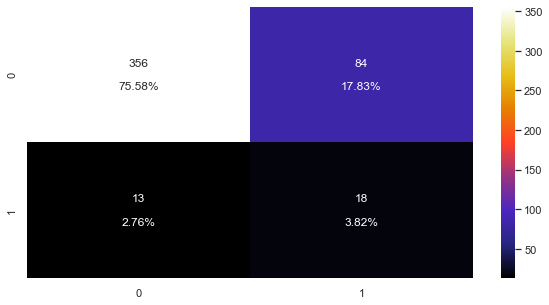

In [55]:
# Predict faulty semiconductors using the test dataset

grid_pred_lg = grid_search_lg.predict(xtest_fil)

# Print the classification report and confusion matrix

print(f'Classification report: \n\n {classification_report(ytest, grid_pred_lg)}')
print('\n')
print(f'The Accuracy Score is {accuracy_score(ytest, grid_pred_lg)}')
print('\n')
print(f'The ROC-AUC Score is {roc_auc_score(ytest, grid_pred_lg)}')
print('\n')
print('Confusion Matrix:')
cf_matrix = confusion_matrix(ytest, grid_pred_lg)

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [group_counts,group_percentages]
labels = [f"{v1}\n\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, cmap='CMRmap', fmt='')
sns.set(rc={'figure.figsize':(10,5)})

#### Hyperparameter tuning of Random Forest Model

In [57]:
RF_model = RandomForestClassifier()

params_rf = [{
            'n_estimators': [25, 50, 100, 200, 400, 600, 800, 1000],
            'max_features': ['auto', 'sqrt'],
            'bootstrap': [True, False],
            'max_depth': [5, 10, 20, 30, 40, 50, 60, 70],
            'min_samples_split': [2, 5, 10],
            'max_samples' : [98],
            'min_samples_leaf': [1, 2, 4]
        }]

In [58]:
grid_search_rf = GridSearchCV(RF_model, param_grid= params_rf, cv = 5, verbose = True, n_jobs= -1)
grid_search_rf.fit(xtrain_sm,ytrain_sm)

Fitting 5 folds for each of 2304 candidates, totalling 11520 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid=[{'bootstrap': [True, False],
                          'max_depth': [5, 10, 20, 30, 40, 50, 60, 70],
                          'max_features': ['auto', 'sqrt'], 'max_samples': [98],
                          'min_samples_leaf': [1, 2, 4],
                          'min_samples_split': [2, 5, 10],
                          'n_estimators': [25, 50, 100, 200, 400, 600, 800,
                                           1000]}],
             verbose=True)

In [59]:
print("Best Score : %f using %s" %(grid_search_rf.best_score_, grid_search_rf.best_params_))


Best Score : 0.811329 using {'bootstrap': True, 'max_depth': 60, 'max_features': 'sqrt', 'max_samples': 98, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400}


Classification report: 

               precision    recall  f1-score   support

          -1       0.96      0.75      0.84       440
           1       0.13      0.52      0.21        31

    accuracy                           0.74       471
   macro avg       0.54      0.64      0.53       471
weighted avg       0.90      0.74      0.80       471



The Accuracy Score is 0.7388535031847133


The ROC-AUC Score is 0.6353372434017596


Confusion Matrix:


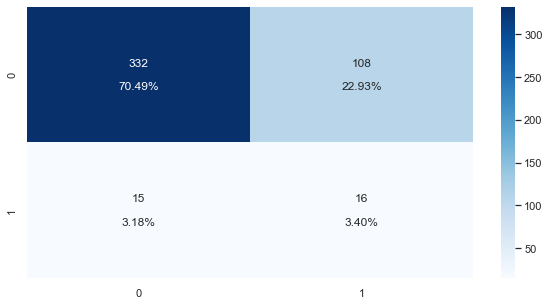

In [60]:
# Predict faulty semiconductors using the test dataset

grid_pred_rf = grid_search_rf.predict(xtest_fil)

# Print the classification report and confusion matrix

print(f'Classification report: \n\n {classification_report(ytest, grid_pred_rf)}')
print('\n')
print(f'The Accuracy Score is {accuracy_score(ytest, grid_pred_rf)}')
print('\n')
print(f'The ROC-AUC Score is {roc_auc_score(ytest, grid_pred_rf)}')
print('\n')
print('Confusion Matrix:')
cf_matrix = confusion_matrix(ytest, grid_pred_rf)

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [group_counts,group_percentages]
labels = [f"{v1}\n\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, cmap='Blues', fmt='')
sns.set(rc={'figure.figsize':(10,5)})

#### Hyperparameter tuning of Support Vector Machine

In [61]:
svm_model = SVC()

params_svm = [ {
            'C': [0.1, 1, 10, 100, 1000],
            'gamma': [100, 10, 1, 0.1, 0.01, 0.001, 0.0001, 'scale', 'auto'],
            'kernel': ['rbf','poly', 'linear', 'sigmoid']
            }]

In [62]:
grid_search_svm = GridSearchCV(svm_model, param_grid= params_svm, cv = 5, verbose = True, n_jobs= -1)
grid_search_svm.fit(xtrain_sm,ytrain_sm)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid=[{'C': [0.1, 1, 10, 100, 1000],
                          'gamma': [100, 10, 1, 0.1, 0.01, 0.001, 0.0001,
                                    'scale', 'auto'],
                          'kernel': ['rbf', 'poly', 'linear', 'sigmoid']}],
             verbose=True)

In [63]:
print("Best score: %f using parameters : %s" % (grid_search_svm.best_score_, grid_search_svm.best_params_))

Best score: 0.958942 using parameters : {'C': 100, 'gamma': 10, 'kernel': 'rbf'}


Classification report: 

               precision    recall  f1-score   support

          -1       0.94      0.93      0.93       440
           1       0.11      0.13      0.12        31

    accuracy                           0.87       471
   macro avg       0.52      0.53      0.53       471
weighted avg       0.88      0.87      0.88       471



The Accuracy Score is 0.8747346072186837


The ROC-AUC Score is 0.5281524926686216


Confusion Matrix:


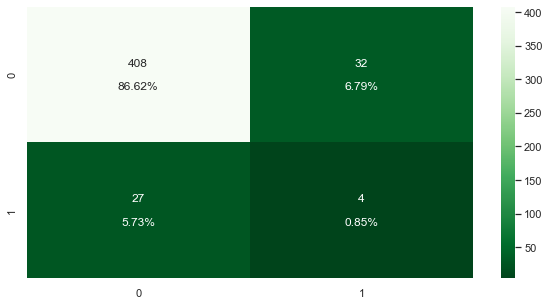

In [65]:
# Predict faulty semiconductors using the test dataset

grid_pred_svm = grid_search_svm.predict(xtest_fil)

clf = SVC(C=10.0, gamma=1.0, kernel='linear')
clf.fit(xtrain_sm,ytrain_sm)
ypred = clf.predict(xtest_fil)



# Print the classification report and confusion matrix

print(f'Classification report: \n\n {classification_report(ytest, grid_pred_svm)}')
print('\n')
print(f'The Accuracy Score is {accuracy_score(ytest, grid_pred_svm)}')
print('\n')
print(f'The ROC-AUC Score is {roc_auc_score(ytest, grid_pred_svm)}')
print('\n')
print('Confusion Matrix:')
cf_matrix = confusion_matrix(ytest, grid_pred_svm)

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [group_counts,group_percentages]
labels = [f"{v1}\n\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, cmap='Greens_r', fmt='')
sns.set(rc={'figure.figsize':(10,5)})

#### Hyperparameter tuning of Naive Bayes

In [66]:
nb_model = GaussianNB()

params_nb = [ {'var_smoothing': np.logspace(0,-9, num=1000)}]

In [67]:
grid_search_nb= GridSearchCV(nb_model, param_grid= params_nb, cv = 5, verbose = True, n_jobs= -1)
grid_search_nb.fit(xtrain_sm,ytrain_sm)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


GridSearchCV(cv=5, estimator=GaussianNB(), n_jobs=-1,
             param_grid=[{'var_smoothing': array([1.00000000e+00, 9.79469667e-01, 9.59360829e-01, 9.39664831e-01,
       9.20373200e-01, 9.01477631e-01, 8.82969996e-01, 8.64842328e-01,
       8.47086827e-01, 8.29695852e-01, 8.12661920e-01, 7.95977700e-01,
       7.79636013e-01, 7.63629826e-01, 7.47952252e-01, 7.32596543e-01,
       7.17556092e-01, 7.028244...
       1.61141428e-09, 1.57833141e-09, 1.54592774e-09, 1.51418933e-09,
       1.48310251e-09, 1.45265393e-09, 1.42283046e-09, 1.39361927e-09,
       1.36500781e-09, 1.33698374e-09, 1.30953502e-09, 1.28264983e-09,
       1.25631660e-09, 1.23052400e-09, 1.20526094e-09, 1.18051653e-09,
       1.15628013e-09, 1.13254132e-09, 1.10928986e-09, 1.08651577e-09,
       1.06420924e-09, 1.04236067e-09, 1.02096066e-09, 1.00000000e-09])}],
             verbose=True)

In [68]:
print("Best score: %f using parameters : %s" % (grid_search_nb.best_score_, grid_search_nb.best_params_))

Best score: 0.671544 using parameters : {'var_smoothing': 0.07028244264308349}


Classification report: 

               precision    recall  f1-score   support

          -1       0.97      0.82      0.88       440
           1       0.18      0.58      0.28        31

    accuracy                           0.80       471
   macro avg       0.57      0.70      0.58       471
weighted avg       0.91      0.80      0.84       471



The Accuracy Score is 0.8004246284501062


The ROC-AUC Score is 0.6982771260997067


Confusion Matrix:


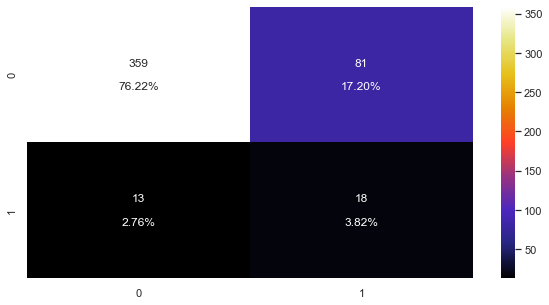

In [69]:
# Predict faulty semiconductors using the test dataset

grid_pred_nb = grid_search_nb.predict(xtest_fil)

# Print the classification report and confusion matrix

print(f'Classification report: \n\n {classification_report(ytest, grid_pred_nb)}')
print('\n')
print(f'The Accuracy Score is {accuracy_score(ytest, grid_pred_nb)}')
print('\n')
print(f'The ROC-AUC Score is {roc_auc_score(ytest, grid_pred_nb)}')
print('\n')
print('Confusion Matrix:')
cf_matrix = confusion_matrix(ytest, grid_pred_nb)

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [group_counts,group_percentages]
labels = [f"{v1}\n\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, cmap='CMRmap', fmt='')
sns.set(rc={'figure.figsize':(10,5)})

### Visualizing each model's performance for predicting faulty wafers

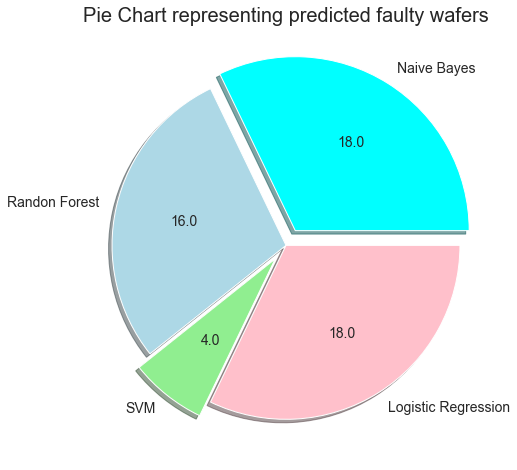

In [78]:

labels = "Naive Bayes", "Randon Forest", "SVM", "Logistic Regression"
# size corresponds to the test accuracies  of each model
sizes = np.array([18, 16, 4, 18])
colors = ['cyan', 'lightblue', 'lightgreen', 'pink', 'orange', 'yellow', 'crimson', 'gray', 'magenta']
explode = [0.1, 0, 0.1, 0]

def absolute_value(val):
    a  = np.round(val/100.*sizes.sum(), 0)
    return a

plt.rcParams['figure.figsize'] = (12, 8)
plt.pie(sizes, colors = colors, explode = explode, labels = labels, shadow = True, autopct = absolute_value,textprops={'fontsize': 14}) 
plt.title('Pie Chart representing predicted faulty wafers', fontsize = 20)
plt.axis('off')
#plt.legend(labels, loc = 'upper right')
plt.show()

### Overall cost assessment based on type 1 and type 2 errors

<img src='pp.jpg' style='width:1400px;height:250px'/>

#### The above diagram shows the Naive Bayes is a better performer amoung the other classification machine learning models since Naive Bayes has the least overall cost. Therefore from an economic standpoint, the company will be more beneficial when implementing Naive Bayes for fault detection in their semiconductor manufacturing process.